# Imports & Drive

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

%cd drive/MyDrive/ProjectML/data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1IxvmZcUIWJGfT71uBwgUz69EsWaNvayC/ProjectML/data


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import models, transforms
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Loading & Preprocessing

In [ ]:
TRAIN_PATH = "training.npz"
TEST_PATH  = "testing.npz"

In [ ]:
train_npz = np.load(TRAIN_PATH, allow_pickle=True)
test_npz  = np.load(TEST_PATH,  allow_pickle=True)

X_full      = train_npz['images']
y_full      = train_npz['labels']
class_names = train_npz['class_names']

X_test = test_npz['images']
y_test = test_npz['labels']

print("Full (to split):", X_full.shape, y_full.shape)
print("Test:", X_test.shape, y_test.shape)
print("Class names:", class_names)

X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full,
    test_size=0.2,
    random_state=42,
    stratify=y_full
)

print("Train:", X_train.shape, y_train.shape)
print("Val:",   X_val.shape,   y_val.shape)
print("Test:",  X_test.shape,  y_test.shape)

Full (to split): (5712, 256, 256, 3) (5712,)
Test: (1311, 256, 256, 3) (1311,)
Class names: ['glioma' 'meningioma' 'notumor' 'pituitary']
Train: (4569, 256, 256, 3) (4569,)
Val: (1143, 256, 256, 3) (1143,)
Test: (1311, 256, 256, 3) (1311,)


In [ ]:
class NumpyDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        img = self.X[idx]
        label = self.y[idx]

        if img.ndim == 3 and img.shape[-1] in [1,3]:
            img = np.transpose(img, (2,0,1))

        img = torch.from_numpy(img).float()
        if self.transform:
            img = self.transform(img)

        label = torch.tensor(label).long()
        return img, label


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ]),
    'val': transforms.Compose([
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ]),
    'test': transforms.Compose([
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ]),
}

batch_size = 32
num_workers = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_ds = NumpyDataset(X_train, y_train, transform=data_transforms['train'])
val_ds   = NumpyDataset(X_val,   y_val,   transform=data_transforms['val'])
test_ds  = NumpyDataset(X_test,  y_test,  transform=data_transforms['test'])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

dataset_sizes = {'train': len(train_ds), 'val': len(val_ds), 'test': len(test_ds)}
print(dataset_sizes)

{'train': 4569, 'val': 1143, 'test': 1311}


# Model

In [ ]:
num_classes = len(np.unique(y_train))

model = models.mobilenet_v2(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

# Freeze
for param in model.features.parameters():
    param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Training

**Early stopping logic**

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0, verbose=False):
        """
        Args:
            patience (int): how many epochs to wait after last improvement
            min_delta (float): minimal change to qualify as an improvement
            verbose (bool): whether to print when early‐stop is triggered
        """
        self.patience    = patience
        self.min_delta   = min_delta
        self.verbose     = verbose
        self.best_loss   = float('inf')
        self.counter     = 0
        self.early_stop  = False

    def __call__(self, val_loss, model, best_model_wts):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss  = val_loss
            self.counter    = 0
            best_model_wts  = model.state_dict().copy()
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        return best_model_wts


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5, early_stopping=None):
    best_model_wts = model.state_dict().copy()
    best_acc = 0.0

    history = {
        'train_loss': [],
        'val_loss':   [],
        'train_acc':  [],
        'val_acc':    []
    }

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-'*20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            with tqdm(dataloader, unit="batch", desc=f"{phase} Epoch {epoch+1}") as tepoch:
                for inputs, labels in tepoch:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                    current_loss = running_loss / ((tepoch.n * tepoch.last_print_n) if tepoch.last_print_n else 1)
                    tepoch.set_postfix(loss=f"{loss.item():.4f}")

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc  = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

                if early_stopping is not None:
                    best_model_wts = early_stopping(epoch_loss, model, best_model_wts)
                    if early_stopping.early_stop:
                        print("Early stopping triggered.")
                        model.load_state_dict(best_model_wts)
                        return model, history

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict().copy()



    print(f"Best val Acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model, history


**Hyperparamms**

In [ ]:
LR = 1e-5
STEP_SIZE = 7
GAMMA = 0.1
EPOCHS = 30
BATCH_SIZE = 32
PATIENCE = 3

In [ ]:
for param in model.features.parameters():
    param.requires_grad = True

optimizer_ft = optim.Adam(model.parameters(), lr=LR)
exp_lr_scheduler_ft = lr_scheduler.StepLR(optimizer_ft, step_size=STEP_SIZE, gamma=GAMMA)

es = EarlyStopping(patience=PATIENCE, min_delta=0.01, verbose=True)

model, history = train_model(
    model,
    criterion,
    optimizer_ft,
    exp_lr_scheduler_ft,
    num_epochs=EPOCHS,
    early_stopping=es
)

Epoch 1/30
--------------------


train Epoch 1:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.9600 Acc: 0.6214


val Epoch 1:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.5388 Acc: 0.8583
Epoch 2/30
--------------------


train Epoch 2:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.4241 Acc: 0.8720


val Epoch 2:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.3328 Acc: 0.8915
Epoch 3/30
--------------------


train Epoch 3:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.3044 Acc: 0.9028


val Epoch 3:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.2528 Acc: 0.9116
Epoch 4/30
--------------------


train Epoch 4:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.2524 Acc: 0.9160


val Epoch 4:   0%|          | 0/36 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3d621d8e00>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7a3d621d8e00>    self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
        if w.is_alive():
self._shutdown_workers()
    File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
     if w.is_alive(): 
        ^ ^^ ^^^^^^^^^^^^^^^^^^^^^

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
        assert self.

val Loss: 0.2088 Acc: 0.9291
Epoch 5/30
--------------------


train Epoch 5:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.2136 Acc: 0.9293


val Epoch 5:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.1861 Acc: 0.9388
Epoch 6/30
--------------------


train Epoch 6:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.1789 Acc: 0.9378


val Epoch 6:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.1484 Acc: 0.9475
Epoch 7/30
--------------------


train Epoch 7:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.1618 Acc: 0.9483


val Epoch 7:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.1288 Acc: 0.9545
Epoch 8/30
--------------------


train Epoch 8:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.1440 Acc: 0.9508


val Epoch 8:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.1279 Acc: 0.9563
EarlyStopping counter: 1 out of 3
Epoch 9/30
--------------------


train Epoch 9:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.1403 Acc: 0.9554


val Epoch 9:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.1283 Acc: 0.9589
EarlyStopping counter: 2 out of 3
Epoch 10/30
--------------------


train Epoch 10:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.1350 Acc: 0.9569


val Epoch 10:   0%|          | 0/36 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3d621d8e00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
   Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a3d621d8e00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1610, in _shutdown_workers
    self._pin_memory_thread.join()
  File "/usr/lib/python3.12/threading.py", line 1146, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread
 Exception ignored in:   <function _MultiProc

val Loss: 0.1239 Acc: 0.9589
EarlyStopping counter: 3 out of 3
Early stopping triggered.


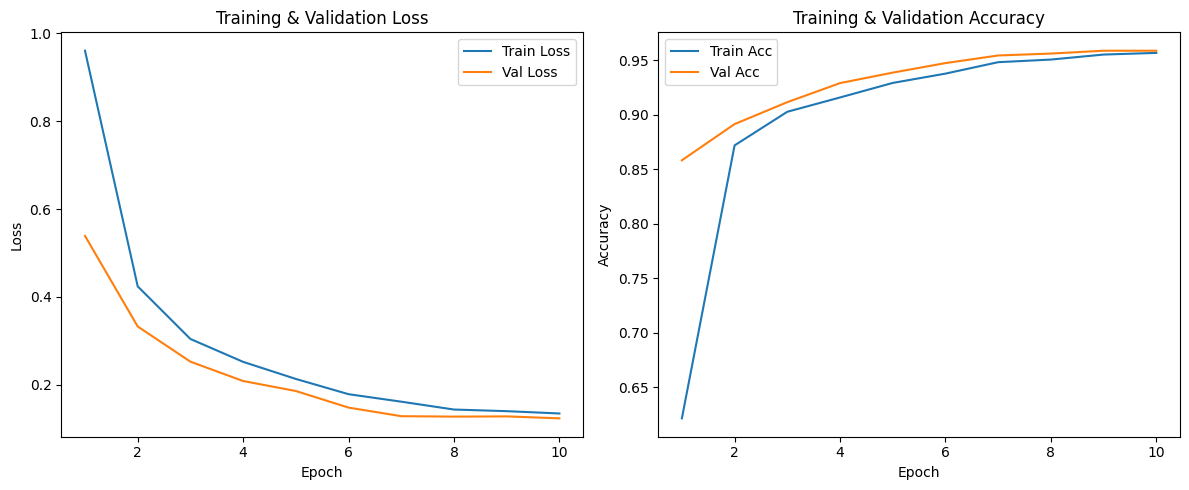

In [ ]:
epochs = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(12,5))

# Loss subplot
plt.subplot(1,2,1)
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'],   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Accuracy subplot
plt.subplot(1,2,2)
plt.plot(epochs, history['train_acc'], label='Train Acc')
plt.plot(epochs, history['val_acc'],   label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Testing

Classification Report:
              precision    recall  f1-score   support

      glioma       0.96      0.94      0.95       300
  meningioma       0.91      0.91      0.91       306
     notumor       0.95      0.99      0.97       405
   pituitary       0.98      0.96      0.97       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



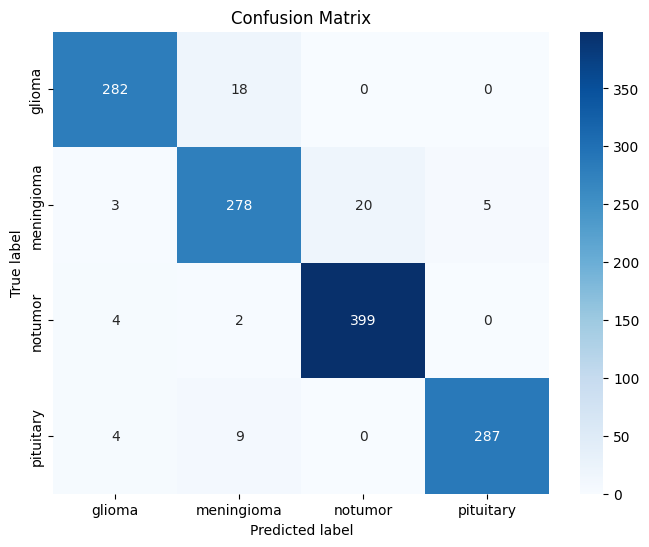

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap=plt.cm.Blues)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# Save Checkpoint

In [ ]:
torch.save(model.state_dict(), 'models/mobilenetv2_finetuned.pth')